In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.autolayout"] = True

In [2]:
import torch
from torch import nn, optim
from testfuncs import Legendre_Polynomials, Finite_Elements
from utils import plot_train_process
import torch.nn.functional as F

## Define the parameters of the equation

In [3]:
# f = lambda x: x ** -.25  # Source function
f = lambda x: 10  # Source function
k = 2. * (np.pi / 2)  # frequency
a, b = -1., +1.  # Domain
ga, gb = 5., 0.  # Values at the boundaries

## Get the exact solution

In [4]:
from solvers import Exact_HelmholtzImpedance_const
u, u_x, u_xx = Exact_HelmholtzImpedance_const(f(0), k, a, b, ga, gb)

# Check that the solution satisfies boundary conditions
assert np.allclose(- u_x(a) - 1j * k * u(a), ga)
assert np.allclose(+ u_x(b) - 1j * k * u(b), gb)
for x in np.linspace(a, b, 100):
    assert np.allclose(- u_xx(x) - k ** 2 * u(x), f(x))

## Define the model

In [65]:
from solvers import VPINN_HelmholtzImpedance

testfuncs = 10
width = 50
depth = 1
activation = F.relu
penalty = None

cuda = False
seed = None
dropout_probs = None

model = VPINN_HelmholtzImpedance(f=f, k=k, a=a, b=b, ga=ga, gb=gb,
                                layers=[1] + [width for _ in range(depth)] + [2],
                                activation=activation,
                                dropout_probs=dropout_probs,
                                penalty=penalty,
                                quad_N=100,
                                seed=seed,
                                cuda=cuda,
                                )

if cuda:
  model = model.cuda()

# testfunctions = Legendre_Polynomials(testfuncs - 1, a, b)()
testfunctions = Finite_Elements(testfuncs - 1, a, b, dtype=torch.Tensor)()

## Train the network

### Perfect initialization (to check the network, loss function, etc.)

In [40]:
points = torch.linspace(a - 1e-06, b, width + 1).float()
derivs = torch.zeros_like(model.lins[1].weight)
for i, point, next in zip(range(width), points[:-1], points[1:]):
    derivs[0, i] = .5 * (u_x(point).real + u_x(next).real)
    derivs[1, i] = .5 * (u_x(point).imag + u_x(next).imag)
steps = derivs.clone()
for i in range(width - 1):
    steps[0, i + 1] = derivs[0, i + 1] - derivs[0, i]
    steps[1, i + 1] = derivs[1, i + 1] - derivs[1, i]

model.lins[0].bias = nn.Parameter(-1 * points[:-1])
model.lins[1].weight = nn.Parameter(steps.float())
model.lins[1].bias = nn.Parameter(torch.tensor([u(a).real, u(a).imag]).float())

### Custom initialization

In [18]:
points = torch.linspace(a - 1e-06, b, width + 1).float()
# derivs = torch.ones_like(model.lins[1].weight)
# for i in range(0, width, 2):
#     derivs[0, i] *= -1.
#     derivs[1, i] *= -1.
# steps = derivs.clone()
# for i in range(width - 1):
#     steps[0, i + 1] = derivs[0, i + 1] - derivs[0, i]
#     steps[1, i + 1] = derivs[1, i + 1] - derivs[1, i]

model.lins[0].bias = nn.Parameter(-1 * points[:-1])
# model.lins[1].weight = nn.Parameter(steps.float())
# model.lins[1].bias = nn.Parameter(torch.tensor([-1., -1.]).float())

### Train

In [66]:
# optimizer = optim.Adam([
#   # {'params': model.lins[0].weight, 'lr': 1e-04},
#   # {'params': model.lins[0].bias, 'lr': 1e-03},
#   {'params': model.lins[1].weight, 'lr': 1e-02},
#   {'params': model.lins[1].bias, 'lr': 1e-02},
#   ], lr=lr

optimizer = optim.SGD([
  # {'params': model.lins[0].weight, 'lr': 1e-04},
  {'params': model.lins[0].bias, 'lr': 1e-04},
  {'params': model.lins[1].weight, 'lr': 1e-03},
  {'params': model.lins[1].bias, 'lr': 1e-03},
  ], lr=1e-03, momentum=.5)

epochs = 60000

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=.1, last_epoch=-1)

losses, errors = model.train_(testfunctions, 15000, optimizer, scheduler, exact=(u, u_x))
plot_train_process(losses, errors)

Epoch 000000 / 15000: loss = 2.692e+01, H1-error = 7.913e+01
Epoch 000050 / 15000: loss = 1.937e+00, H1-error = 5.334e+01
Epoch 000100 / 15000: loss = 1.318e+00, H1-error = 5.320e+01
Epoch 000150 / 15000: loss = 1.124e+00, H1-error = 5.280e+01
Epoch 000200 / 15000: loss = 1.023e+00, H1-error = 5.203e+01
Epoch 000250 / 15000: loss = 9.474e-01, H1-error = 5.102e+01
Epoch 000300 / 15000: loss = 8.860e-01, H1-error = 4.996e+01
Epoch 000350 / 15000: loss = 8.337e-01, H1-error = 4.886e+01
Epoch 000400 / 15000: loss = 7.831e-01, H1-error = 4.780e+01
Epoch 000450 / 15000: loss = 7.428e-01, H1-error = 4.675e+01
Epoch 000500 / 15000: loss = 6.964e-01, H1-error = 4.584e+01
Epoch 000550 / 15000: loss = 6.640e-01, H1-error = 4.493e+01
Epoch 000600 / 15000: loss = 6.247e-01, H1-error = 4.397e+01
Epoch 000650 / 15000: loss = 5.949e-01, H1-error = 4.308e+01
Epoch 000700 / 15000: loss = 5.643e-01, H1-error = 4.224e+01
Epoch 000750 / 15000: loss = 5.368e-01, H1-error = 4.142e+01
Epoch 000800 / 15000: lo

## Plot the parameters

Last layer bias: Parameter containing:
tensor([-0.0123,  0.8247], requires_grad=True)


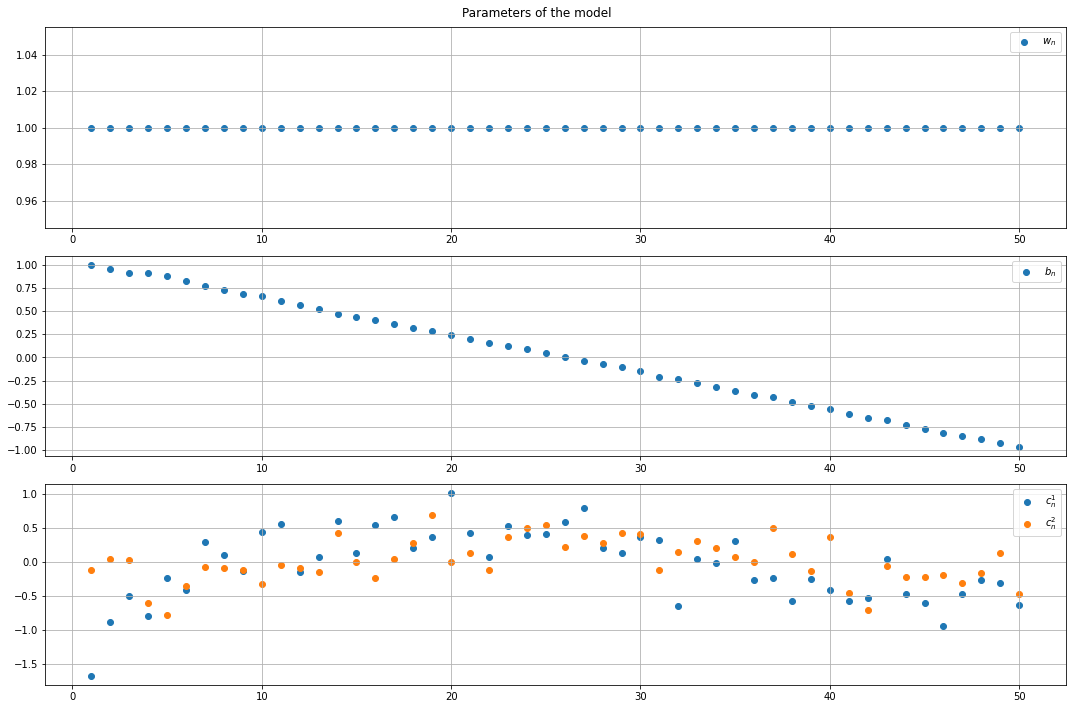

In [58]:
print(f'Last layer bias: {model.lins[1].bias}')

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=4.0)
fig.suptitle(f'Parameters of the model')

axs[0].scatter(np.arange(1, width + 1), model.lins[0].weight.detach().view(-1).numpy(), label='$w_n$')
axs[1].scatter(np.arange(1, width + 1), model.lins[0].bias.detach().view(-1).numpy(), label='$b_n$')
axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[0].detach().view(-1).numpy(), label='$c^1_n$')
axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[1].detach().view(-1).numpy(), label='$c^2_n$')
for ax in axs:
    ax.grid()
    ax.legend()

## Evaluate the results

In [54]:
errs = model.H1_error(u, u_x)
print(f'H1-error: \t\t{errs[0].item():.2e}')
print(f'Solution L2-error: \t{errs[1].item():.2e}')
print(f'Derivative L2-error: {errs[2].item():.2e}')

H1-error: 		8.21e+00
Solution L2-error: 	6.01e-01
Derivative L2-error: 7.61e+00


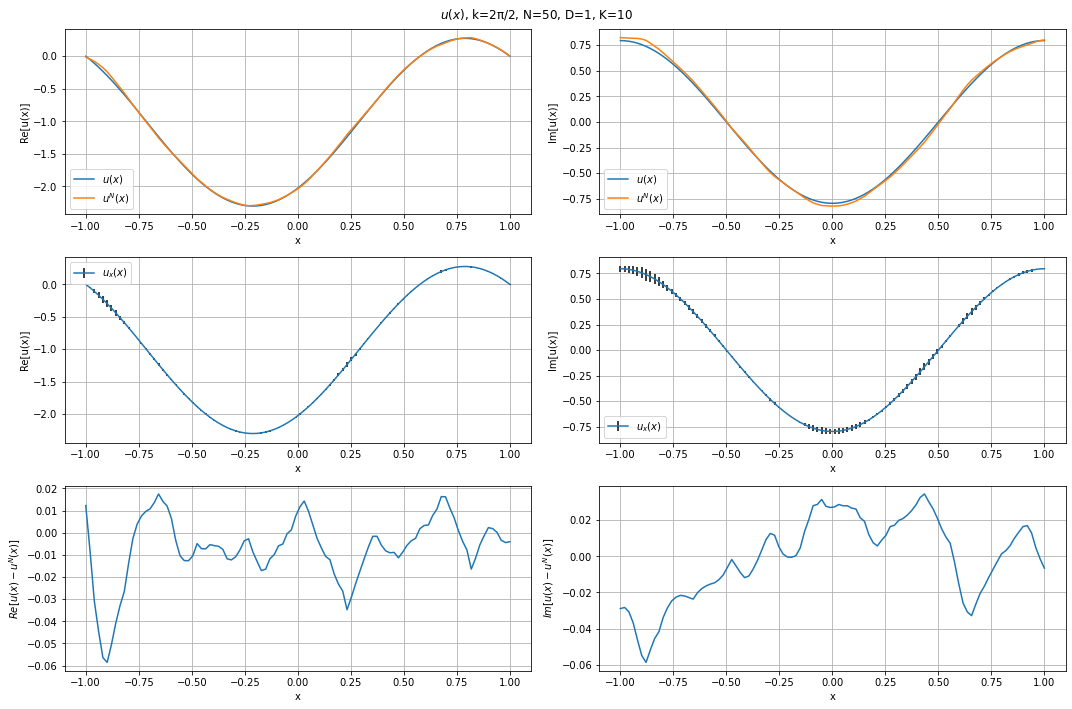

In [59]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = u(xpts).real, u(xpts).imag
rpts_re, rpts_im = model.deriv(0, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].errorbar(xpts, upts_re.view(-1), yerr=(upts_re - rpts_re).view(-1), ecolor='black', label='$u_x(x)$')
axs[1, 0].set(xlabel='x', ylabel='Re[u(x)]')
axs[1, 0].legend()
axs[1, 0].grid()
axs[1, 1].errorbar(xpts, upts_im.view(-1), yerr=(upts_im - rpts_im).view(-1), ecolor='black', label='$u_x(x)$')
axs[1, 1].set(xlabel='x', ylabel='Im[u(x)]')
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 0].plot(xpts, upts_re - rpts_re)
axs[2, 0].set(xlabel='x', ylabel='$Re[u(x)-u^N(x)]$')
axs[2, 0].grid()
axs[2, 1].plot(xpts, upts_im - rpts_im)
axs[2, 1].set(xlabel='x', ylabel='$Im[u(x)-u^N(x)]$')
axs[2, 1].grid()

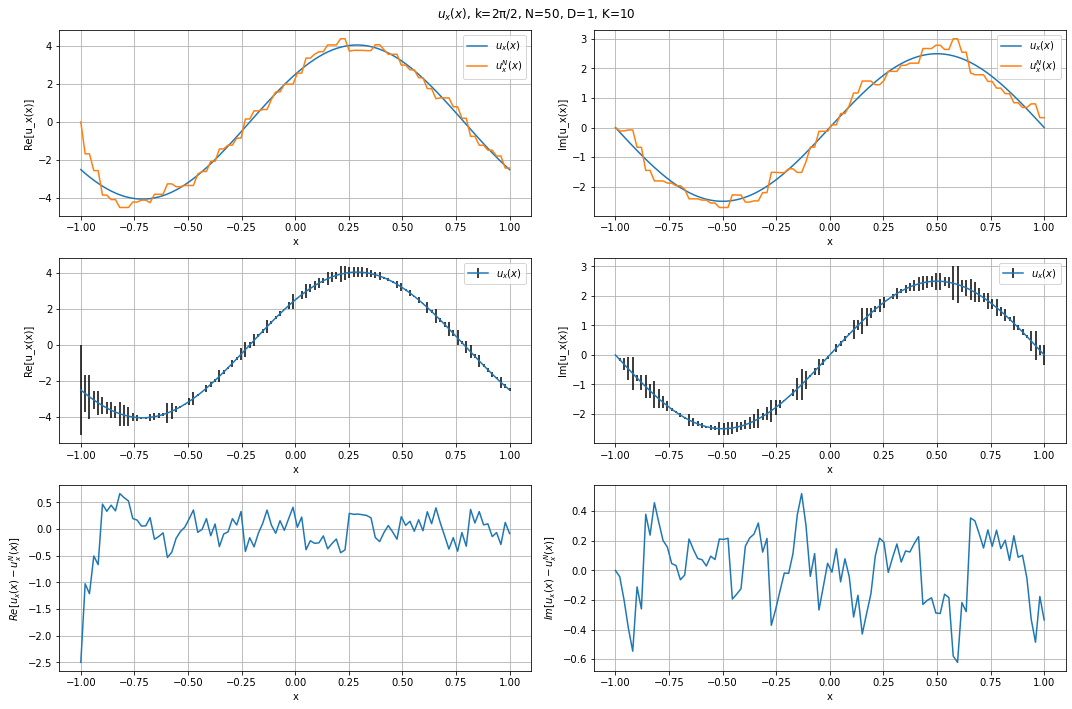

In [60]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = u_x(xpts).real, u_x(xpts).imag
xpts.requires_grad_()
rpts_re, rpts_im = model.deriv(1, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u_x(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u_x(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N_x(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u_x(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N_x(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

axs[1, 0].errorbar(xpts, upts_re.view(-1), yerr=(upts_re - rpts_re).view(-1), ecolor='black', label='$u_x(x)$')
axs[1, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
axs[1, 0].legend()
axs[1, 0].grid()
axs[1, 1].errorbar(xpts, upts_im.view(-1), yerr=(upts_im - rpts_im).view(-1), ecolor='black', label='$u_x(x)$')
axs[1, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
axs[1, 1].legend()
axs[1, 1].grid()

axs[2, 0].plot(xpts, upts_re - rpts_re)
axs[2, 0].set(xlabel='x', ylabel='$Re[u_x(x)-u^N_x(x)]$')
axs[2, 0].grid()
axs[2, 1].plot(xpts, upts_im - rpts_im)
axs[2, 1].set(xlabel='x', ylabel='$Im[u_x(x)-u^N_x(x)]$')
axs[2, 1].grid()